## The fully explicit trial

After so many times of failure, I decided to try the simplest fully explicit scheme on this fractional time step method. This scheme means to treat convective term also fully explicitly.

Step 1:

\begin{equation}
u^\ast_{i,j} = (1-4\frac{\nu \Delta t}{\delta^2})u^n_{i,j} + \frac{\nu \Delta t}{\delta^2}(u^n_{i+1,j}+u^n_{i-1,j}+u^n_{i,j+1}+u^n_{i,j-1}) - \frac{\Delta t}{2\delta}(u^n_{i,j}(u^n_{i+1,j}-u^n_{i-1,j})+v^n_{i,j}(u^n_{i,j+1}-u^n_{i,j-1}))
\end{equation}

The same coefficients go for velocity v.

Step 2:

pressure $p^{n+1}$

\begin{equation}
\nabla^2 p^{n+1}_{i,j} = \frac{u^\ast_{i+1,j}-u^\ast_{i-1,j} + v^\ast_{i,j+1}-v^\ast_{i,j-1}}{2\Delta t \delta}
\end{equation}

velocity u

\begin{equation}
u^{n+1}_{i,j}=u^\ast_{i,j}-\frac{\Delta t}{2\delta} (p^{n+1}_{i+1,j}-p^{n+1}_{i-1,j})
\end{equation}

velocity v

\begin{equation}
v^{n+1}_{i,j}=v^\ast_{i,j}-\frac{\Delta t}{2\delta} (p^{n+1}_{i,j+1}-p^{n+1}_{i,j-1})
\end{equation}

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

from laplace_helper import L2_rel_error

In [2]:
xmin = 0; xmax = 10
ymin = 0; ymax = 10
nx = 41
ny = 41

l2_target = 1e-5

T = 1
dt = 0.001
nt = int(T/dt+1)

In [3]:
dx = (xmax-xmin)/(nx-1)
dy = (ymax-ymin)/(ny-1)

# Mesh
x  = np.linspace(xmin,xmax,nx)
y  = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y)

In [4]:
def solve_Poisson(p, b, dx, dy, l2_target):
    """ Solve Poisson equation for pressure in step 2

    Returns:
    -------
    p: 2D array of floats
        Pressure at time step (n+1)
    """
    # Initialize
    p = np.zeros((nx,ny))
    
    l2_norm = 1
    #iterations = 0
    l2_conv = []
    
    # Solve
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 +\
                        (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 -\
                         b[1:-1,1:-1]*dx**2*dy**2)
            
        #p[:, -1] = p[:, -2] 
        #p[0, :] = p[1, :]  
        #p[:, 0] = p[:, 1]    
        #p[-1, :] = p[-2,:]
        
        l2_norm = L2_rel_error(pd,p)
        #iterations += 1
        l2_conv.append(l2_norm)

    return p

In [5]:
def step1_explicit(nx, ny, u, v):
    """ Solve step 1 fully exolicitly

    Returns:
    -------
    u_star: 2D array of floats
        intermediate velocity field
    v_star: 2D array of floats
        intermediate velocity field
    """
    u_star = np.zeros((ny, nx))
    v_star = np.zeros((ny, nx))
    
    u_star[1:-1,1:-1] = (1-4*nu*dt/(dh**2))*u[1:-1,1:-1] + nu*dt/(dh**2)*(u[:-2,1:-1]+u[2:,1:-1]+u[1:-1,:-2]+u[1:-1,2:]) \
    - dt/(2*dh)*(u[1:-1,1:-1]*(u[1:-1,2:]-u[1:-1,:-2]) + (v[1:-1,1:-1]*(u[2:,1:-1]-u[:-2,1:-1])))
    
    v_star[1:-1,1:-1] = (1-4*nu*dt/(dh**2))*v[1:-1,1:-1] + nu*dt/(dh**2)*(v[:-2,1:-1]+v[2:,1:-1]+v[1:-1,:-2]+v[1:-1,2:]) \
    - dt/(2*dh)*(u[1:-1,1:-1]*(v[1:-1,2:]-v[1:-1,:-2]) + (v[1:-1,1:-1]*(v[2:,1:-1]-v[:-2,1:-1])))
    
    # Enforce BCs
    v_star[0,:] = 0
    v_star[-1,:] = 0
    v_star[:,0] = 0
    v_star[:,-1] = 0
    
    u_star[0,:] = 0
    u_star[-1,:] = 1
    u_star[:,0] = 0
    u_star[:,-1] = 0
    
    return u_star, v_star

In [6]:
def step2_explicit(nx, ny, u_star, v_star, p):
    """ Solve step 2 fully exolicitly

    Returns:
    -------
    u_plus: 2D array of floats
        velocity u at next time step
    v_plus: 2D array of floats
        velocity v at next time step
    """
    u_plus = np.zeros((nx, ny))
    v_plus = np.zeros((nx, ny))
    
    u_plus[:,1:-1] = u_star[:,1:-1] - dt/(2*dh)*(p[:,2:]-p[:,:-2])
    v_plus[1:-1,:] = v_star[1:-1,:] - dt/(2*dh)*(p[2:,:]-p[:-2,:])
  
    # Enforce BCs
    v_plus[0,:] = 0
    v_plus[-1,:] = 0
    v_plus[:,0] = 0
    v_plus[:,-1] = 0
    
    u_plus[0,:] = 0
    u_plus[-1,:] = 1
    u_plus[:,0] = 0
    u_plus[:,-1] = 0
        
    return u_plus, v_plus

In [7]:
nu=10
dh=dx
u = np.zeros((ny,nx))
u[-1,:] = 1
v = np.zeros((ny,nx))

In [8]:
for t in range(nt):
    
    # step 1
    un = u.copy()
    vn = v.copy()
    
    u_star, v_star = step1_explicit(nx, ny, u, v)

    # step 2
    
    # solve p
    p_i = np.zeros((ny,nx))
    b_p = np.zeros((ny,nx))
    b_p[1:-1,1:-1] = (u_star[1:-1,2:] - u_star[1:-1,:-2] + v_star[2:,1:-1] - v_star[:-2,1:-1])/(2*dt*dh)
    #b_p[0,:] = b_p[1,:]
    #b_p[:,0] = b_p[:,1]
    #b_p[-1,:] = b_p[-2,:]
    #b_p[:,-1] = b_p[:,-2]
    p = solve_Poisson(p_i, b_p, dx, dy, l2_target)
    
    # solve for u_n+1
    ustar = u_star.copy()
    vstar = v_star.copy()
    u_plus, v_plus = step2_explicit(nx, ny, ustar, vstar, p)

    
    u = u_plus
    v = v_plus

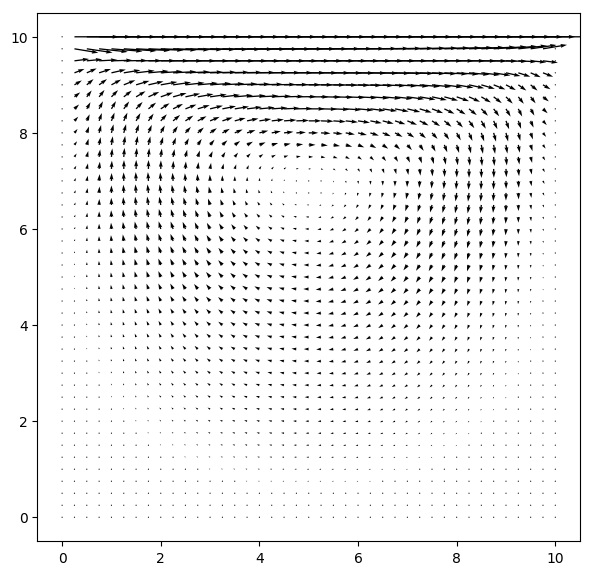

In [9]:
fig = plt.figure(figsize = (7,7), dpi=100)
plt.quiver(X, Y, u, v);

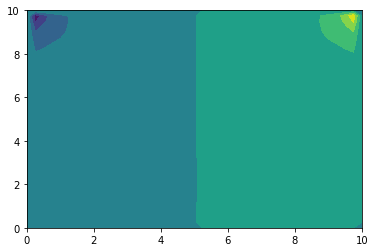

In [13]:
#plt.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
plt.contourf(X,Y,p)

This is the most physical and the closest to real solution results I get so far. A big vortex is formed, but the small vortices are not there. The pressure contour also shows high pressure on the top right corner and low pressure on the top left corner. But the central and bottom areas are not that good. Overall, it's not surprising that this simplest scheme is the only one that really gives results after these three notebooks. Because the easy explicit scheme makes the code short and less likely to have mistakes.